<a href="https://colab.research.google.com/github/X-Xin6/DeLIVR/blob/main/Stage2_DeLiVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from torch import nn, optim


class Stage2Model(nn.Module):
    def __init__(self):
        super(Stage2Model, self).__init__()

        # Define the first part of the network
        self.dense1 = nn.Linear(in_features=1, out_features=64)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(in_features=64, out_features=128)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(in_features=128, out_features=1)

        # Define the skip connection
        self.skip_dense = nn.Linear(in_features=1, out_features=1)

    def forward(self, x):
        # Forward pass through the first part of the network
        x1 = self.dense1(x)
        x1 = self.relu1(x1)
        x1 = self.dense2(x1)
        x1 = self.relu2(x1)
        x1 = self.dense3(x1)

        # Forward pass through the skip connection
        skip_out = self.skip_dense(x)

        # Add the output of the skip connection to the main network's output
        x1 += skip_out

        return x1

# Instantiate the model
stage2_model = Stage2Model()

In [ ]:
def sample_split(expr, pheno, test_ratio, val_ratio, seed=None):
    if seed is None:
        seed = np.random.randint(0, 2**32 - 1)

    # Split the data into training and validation + test sets
    expr_train, expr_temp, pheno_train, pheno_temp = \
        train_test_split(expr, pheno, test_size=val_ratio + test_ratio, random_state=seed)

    # Calculate the proportion of the test set relative to the combined validation and test sets
    test_ratio_adjusted = test_ratio / (val_ratio + test_ratio)

    # Split the validation + test sets into separate validation and test sets
    expr_val, expr_test, pheno_val, pheno_test = \
        train_test_split(expr_temp, pheno_temp, test_size=test_ratio_adjusted, random_state=seed)

    return expr_train, expr_val, expr_test, pheno_train, pheno_val, pheno_test


import torch.optim as optim

def train_stage2(model, X_train, y_train, X_val, y_val, epochs, learning_rate,weight_decay):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    train_losses, val_losses = [], []

    # Reshape the input tensors to have two dimensions: [batch_size, num_features]
    X_train = X_train.view(-1, 1) if len(X_train.shape) == 1 else X_train
    X_val = X_val.view(-1, 1) if len(X_val.shape) == 1 else X_val

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

        if epoch % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}")

    return train_losses, val_losses


In [ ]:
    test_ratio = 0.4
    val_ratio = 0.1
    from google.colab import drive
    drive.mount("/content/drive")
    s2_X_hat=pd.read_csv('/content/drive/MyDrive/colab_data/s2_X_hat_c.csv',header=None).values
    Y=pd.read_csv('/content/drive/MyDrive/colab_data/Y_c.csv',header=None).values

    expr_train, expr_val, expr_test, pheno_train, pheno_val, pheno_test = sample_split(s2_X_hat,Y, test_ratio, val_ratio)
    print(np.shape(expr_train))
    # Reshape the data
    expr_train_tensor = torch.tensor(expr_train, dtype=torch.float32)
    expr_val_tensor = torch.tensor(expr_val, dtype=torch.float32)
    expr_test_tensor = torch.tensor(expr_test, dtype=torch.float32)
    pheno_train_tensor = torch.tensor(pheno_train, dtype=torch.float32)
    pheno_val_tensor = torch.tensor(pheno_val, dtype=torch.float32)
    pheno_test_tensor = torch.tensor(pheno_test, dtype=torch.float32)

    stage2_model = Stage2Model()
    import matplotlib.pyplot as plt

# Assuming 'train_losses' and 'val_losses' are obtained from the training function
    train_losses, val_losses = train_stage2(stage2_model, expr_train_tensor, pheno_train_tensor,expr_val_tensor,  pheno_val_tensor,  epochs=1000, learning_rate=0.003,weight_decay=0.01)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(4500, 1)
Epoch 1/1000, Train Loss: 1.8955392837524414, Val Loss: 1.4818557500839233
Epoch 51/1000, Train Loss: 0.9999122023582458, Val Loss: 0.9686139822006226
Epoch 101/1000, Train Loss: 0.9993707537651062, Val Loss: 0.9678000211715698
Epoch 151/1000, Train Loss: 0.9993259310722351, Val Loss: 0.9679870009422302
Epoch 201/1000, Train Loss: 0.9993018507957458, Val Loss: 0.9676199555397034
Epoch 251/1000, Train Loss: 0.9993500709533691, Val Loss: 0.9681963324546814
Epoch 301/1000, Train Loss: 0.9993993043899536, Val Loss: 0.9680773019790649
Epoch 351/1000, Train Loss: 0.9994010329246521, Val Loss: 0.9681758880615234
Epoch 401/1000, Train Loss: 0.9995005130767822, Val Loss: 0.9681486487388611
Epoch 451/1000, Train Loss: 0.9996141195297241, Val Loss: 0.9681985378265381
Epoch 501/1000, Train Loss: 0.9996930360794067, Val Loss: 0.9680865406990051
Epoch 551/1000, T

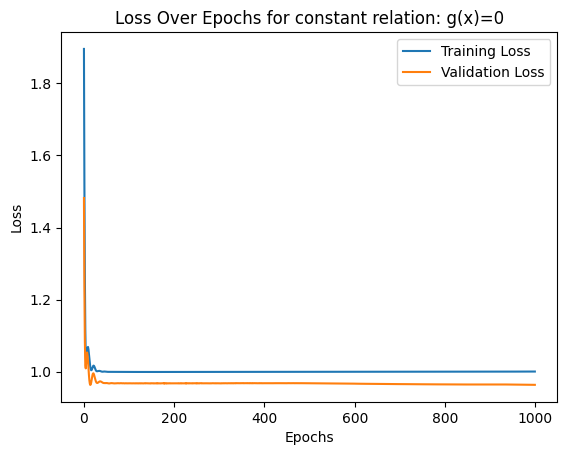

In [ ]:
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs for constant relation: g(x)=0')
    plt.legend()
    plt.show()

MSE: 1.008655071258545, RMSE: 1.0043182373046875, MAE: 0.7974017262458801
[-2.5        -2.49944994 -2.49889989 ...  2.99889989  2.99944994
  3.        ]
[0. 0. 0. ... 0. 0. 0.]


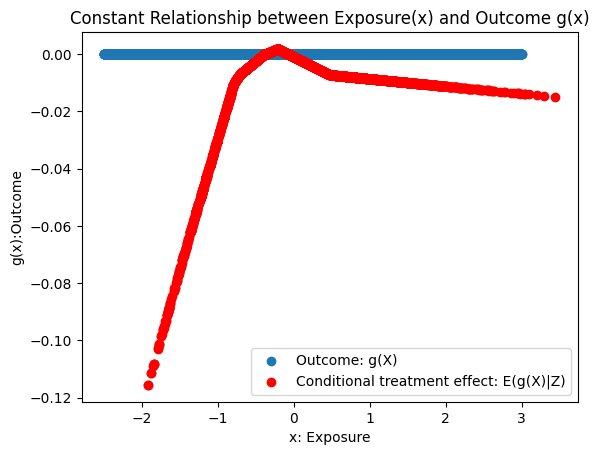

array([[ 0.6560004 ],
       [ 0.51013047],
       [-0.75209165],
       ...,
       [ 0.17918153],
       [ 1.1129874 ],
       [-1.1732777 ]], dtype=float32)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming expr_test_tensor and pheno_test_tensor are your test datasets

# Make predictions
stage2_model.eval()
with torch.no_grad():
    predictions = stage2_model(expr_test_tensor).squeeze()

# Convert predictions and actual values to NumPy for evaluation
predictions_np = predictions.numpy()
actual_np = pheno_test_tensor.numpy()

# Calculate MSE and other metrics
mse = np.mean((predictions_np - actual_np) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions_np - actual_np))

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

# Plot predictions vs actual values
# Generate x values
ran_x = np.linspace(-2.5, 3, 10000)

def g(x):
    return x-x
g_x = g(ran_x)
print(ran_x)
print(g_x)
plt.title('Constant Relationship between Exposure(x) and Outcome g(x)')
plt.xlabel('x: Exposure')
plt.ylabel('g(x):Outcome')
plt.scatter(ran_x, g_x, label="Outcome: g(X)")
plt.scatter(expr_test_tensor.numpy(), predictions_np, label="Conditional treatment effect: E(g(X)|Z)", color="r")
plt.legend()
plt.show()

actual_np

